In [1]:
#Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#preprocessing
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

import os
import tensorflow as tf

In [2]:
#using Apple stock data from 2013 to 2018
df = pd.read_csv(r'/Users/suraj/OneDrive/Documents/csProjects/stockPrices/pricePrediction/AAPL.csv')
df.head(10)

,date,open,high,low,close,volume,Name
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL
5,2013-02-15,66.9785,67.1656,65.7028,65.7371,97924631,AAPL
6,2013-02-19,65.8714,66.1042,64.8356,65.7128,108854046,AAPL
7,2013-02-20,65.3842,65.3842,64.1142,64.1214,118891367,AAPL
8,2013-02-21,63.7142,64.1671,63.2599,63.7228,111596821,AAPL
9,2013-02-22,64.1785,64.5142,63.7999,64.4014,82583823,AAPL


In [3]:
#preprocessing of data
#change to close values
df = df['close'].values
#keras requirement to reshape data
df = df.reshape(-1,1)
#what does the shape look like?
print(df.shape)
#looking at the first 7 entries
df[:7]

(1259, 1)


array([[67.8542],
       [68.5614],
       [66.8428],
       [66.7156],
       [66.6556],
       [65.7371],
       [65.7128]])

In [4]:
#create training data set and test data set
#using 80% of data for training
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
#using 20% of data for training
#I subtract 50 to overlap with the training dataset (required for fitting LSTM model)
dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])
print(dataset_train.shape)
print(dataset_test.shape)

(1007, 1)
(302, 1)


In [5]:
#scale the stock price data to a factor of 1
scaler = MinMaxScaler(feature_range=(0,1))
#fit this range on the dataset and apply this range
dataset_train = scaler.fit_transform(dataset_train)
#how does the data look?
dataset_train[:7]

array([[0.15625287],
       [0.1654123 ],
       [0.14315355],
       [0.1415061 ],
       [0.140729  ],
       [0.12883289],
       [0.12851816]])

In [6]:
#apply the scaling to the test data as well
#dont use fit_transform because the test data should not influence the scaling (preprocessing)
#this should be data the model has not been trained on (has not seen)
dataset_test = scaler.transform(dataset_test)
#check data
dataset_test[:7]

array([[0.72529501],
       [0.72244564],
       [0.72102095],
       [0.70884638],
       [0.69550616],
       [0.70081634],
       [0.69058452]])

In [7]:
#helper function to create batches of 50 days
def create_my_dataset(df):
    x = []
    y = []
    #use 1007 data
    for i in range(50, df.shape[0]):
        #0-49 here
        x.append(df[i-50:i, 0])
        #50th here
        y.append(df[i, 0])
    #convert list to array
    x = np.array(x)
    y = np.array(y)
    return x,y

In [8]:
X_train, y_train = create_my_dataset(dataset_train)
X_train[:1]

array([[0.15625287, 0.1654123 , 0.14315355, 0.1415061 , 0.140729  ,
        0.12883289, 0.12851816, 0.10790687, 0.10274433, 0.11153334,
        0.09671274, 0.10812834, 0.09998692, 0.0941224 , 0.07389966,
        0.0546198 , 0.07514561, 0.06500315, 0.07410688, 0.07621153,
        0.08759087, 0.07012425, 0.0699766 , 0.07765564, 0.0983032 ,
        0.12061764, 0.11834203, 0.11388277, 0.11508468, 0.1320708 ,
        0.13515978, 0.13063835, 0.11388277, 0.0964537 , 0.07101273,
        0.07264464, 0.07671147, 0.06881095, 0.06044805, 0.06601727,
        0.06744195, 0.08355772, 0.08104121, 0.07265889, 0.05424938,
        0.06607296, 0.02270299, 0.0028131 , 0.        , 0.0150615 ]])

In [9]:
y_train[:1]

array([0.0288641])

In [10]:
X_test, y_test = create_my_dataset(dataset_test)
X_test[:1]

array([[0.72529501, 0.72244564, 0.72102095, 0.70884638, 0.69550616,
        0.70081634, 0.69058452, 0.70146393, 0.71545173, 0.72956906,
        0.75327062, 0.74485203, 0.7693307 , 0.7693307 , 0.77749025,
        0.779433  , 0.78811062, 0.79212564, 0.79355033, 0.78357754,
        0.78655642, 0.79614066, 0.78966482, 0.78927627, 0.77749025,
        0.7817643 , 0.78008059, 0.78772207, 0.80455925, 0.81854706,
        0.82010126, 0.82839033, 0.82191449, 0.81919464, 0.83162825,
        0.83149873, 0.82877888, 0.83162825, 0.83266438, 0.8312397 ,
        0.85597739, 0.85675449, 0.85688401, 0.85273947, 0.849113  ,
        0.94495539, 0.94210602, 0.94922944, 0.96490097, 0.98096104]])

In [11]:
#reshaping for LSTM
#1. batch 
#2. timesteps
#3. features
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

print(X_train.shape)
print(X_test.shape)

#957 entries 50 timesteps 1 feature (closing price)

(957, 50, 1)
(252, 50, 1)


In [12]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
model = Sequential()
#96 LSTM cells
model.add(LSTM(units=96, return_sequences=True, input_shape=(X_train.shape[1],1)))
#to account for overfitting
model.add(Dropout(0.2))
#input_shape is only defined in the first layer in Keras
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
#default return_sequnce is False for this layer
model.add(LSTM(units=96))
model.add(Dropout(0.2))
#normal layer
model.add(Dense(units=1))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 96)            37632     
_________________________________________________________________
dropout (Dropout)            (None, 50, 96)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 96)            74112     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 96)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 96)                74112     
_________________________________________________________________
dropout_2 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 9

In [21]:
model.compile(loss='mean_squared_error', optimizer ='adam')

In [22]:
if(not os.path.exists(r'/Users/suraj/OneDrive/Documents/csProjects/stockPrices/pricePrediction/lstm_prediction1.h5')):
    #training process
    model.fit(X_train, y_train, epochs=50, batch_size=32)
    model.save(r'/Users/suraj/OneDrive/Documents/csProjects/stockPrices/pricePrediction/lstm_prediction1.h5')

Epoch 1/50
30/30 [==============================] - 2s 51ms/step - loss: 0.0037
Epoch 2/50
30/30 [==============================] - 2s 51ms/step - loss: 0.0020
Epoch 3/50
30/30 [==============================] - 2s 50ms/step - loss: 0.0024
Epoch 4/50
30/30 [==============================] - 2s 51ms/step - loss: 0.0020
Epoch 5/50
30/30 [==============================] - 1s 50ms/step - loss: 0.0024
Epoch 6/50
30/30 [==============================] - 2s 50ms/step - loss: 0.0021
Epoch 7/50
30/30 [==============================] - 2s 50ms/step - loss: 0.0023
Epoch 8/50
30/30 [==============================] - 2s 50ms/step - loss: 0.0022
Epoch 9/50
30/30 [==============================] - 2s 50ms/step - loss: 0.0021
Epoch 10/50
30/30 [==============================] - 2s 50ms/step - loss: 0.0022
Epoch 11/50
30/30 [==============================] - 2s 50ms/step - loss: 0.0022
Epoch 12/50
30/30 [==============================] - 2s 50ms/step - loss: 0.0021
Epoch 13/50
30/30 [==================

In [23]:
model = load_model(r'/Users/suraj/OneDrive/Documents/csProjects/stockPrices/pricePrediction/lstm_prediction1.h5')

range(1007, 1259)


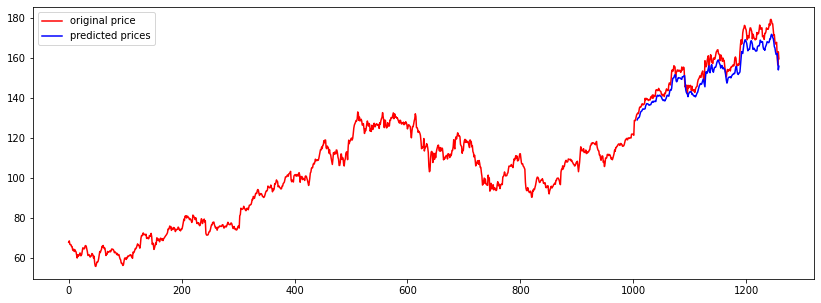

In [24]:
#visualizing predictions
%matplotlib inline
predictions = model.predict(X_test)
#inverse the scaling we did to return actual stock prices not 0-1 values
predictions = scaler.inverse_transform(predictions)

fig, ax = plt.subplots(figsize=(14,5))
plt.plot(df, color='red', label='original price')
ax.plot(range(len(y_train)+50, len(y_train)+50+len(predictions)),predictions,color='blue', label='predicted prices')

plt.legend()

print(range(len(y_train)+50, len(y_train)+50+len(predictions)))

#took in 50 days of stock prices and predicted the 51st 

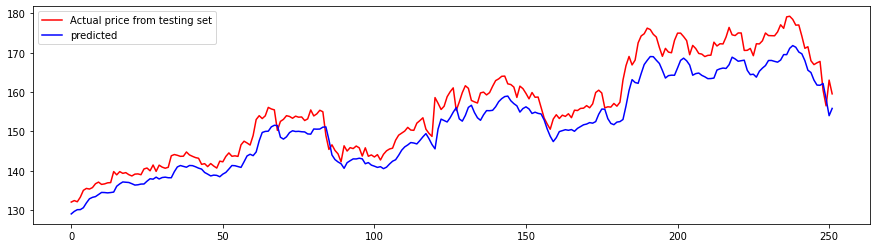

In [26]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

fig, ax = plt.subplots(figsize=(15,4))
ax.plot(y_test_scaled, color='red', label = 'Actual price from testing set')
plt.plot(predictions, color = 'blue', label='predicted')
plt.legend()

#zoomed in